<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Predciting the probability of a link is useful so as to recommend the highest probability links to a user.
- We got to suggest connnections which are most likley to be correct and we should try and not miss out any connnections.(Basically high 'precision' and 'recall')

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix
- Another good option would have been Precision@top10 say if your requirement was to show only top ten predicted nodes.(But we would not be using this here, so as to keep it simple)

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import random

In [2]:
df = pd.read_csv('datasets/data/train.csv')

In [3]:
df.isna()

,source_node,destination_node
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
9437514,False,False
9437515,False,False
9437516,False,False
9437517,False,False


In [4]:
df.isna().any(1).any(),df[df.isna().any(1)]

(False,
 Empty DataFrame
 Columns: [source_node, destination_node]
 Index: [])

>> - - This means there are no NaN in our dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB


In [6]:
df.duplicated().any(),df[df.duplicated()]

(False,
 Empty DataFrame
 Columns: [source_node, destination_node]
 Index: [])

>> - - This means there are no duplicates in our dataset

In [7]:
# Gr = nx.from_pandas_edgelist(df,'source_node','destination_node',None,nx.DiGraph()) # commenting in order to save time when kernel restarts

In [8]:
# print(nx.info(Gr))

>>>> - - - ### AAI Method

In [9]:
#reading graph

# if not os.path.isfile('datasets/data/after_eda/train_woheader.csv'):
#     traincsv = pd.read_csv('datasets/data/train.csv')                         # commenting in order to save time when kernel restarts
#     print(traincsv[traincsv.isna().any(1)])
#     print(traincsv.info())
#     print("Number of diplicate entries: ",sum(traincsv.duplicated()))
#     traincsv.to_csv('datasets/data/after_eda/train_woheader.csv',header=False,index=False)
#     print("saved the graph into file")
# else:
#     g=nx.read_edgelist('datasets/data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
#     print(nx.info(g))

In [10]:
# pickle.dump(g,open('datasets/pickle/Graphg.p','wb'))  # saving graph as pickle

In [11]:
g = pickle.load(open('datasets/pickle/Graphg.p','rb'))
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 1862220\nNumber of edges: 9437519\nAverage in degree:   5.0679\nAverage out degree:   5.0679'

----

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


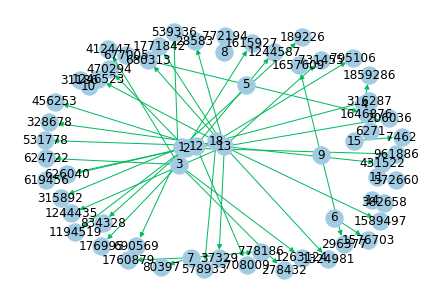

In [12]:
# if not os.path.isfile('train_woheader_sample.csv'):
#     pd.read_csv('data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
# subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
subgraph = nx.from_pandas_edgelist(df[:50],'source_node','destination_node',None,nx.DiGraph())
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
# plt.savefig("graph_sample.pdf") # to save the graph as pdf
print(nx.info(subgraph))

----
>> - # EDA 
----

## 1.1) "The number of unique persons"

In [13]:
pd.unique(df.values.ravel('k')),pd.unique(df.values.ravel('k')).shape

(array([      1,       2,       3, ..., 1510307,  446775,  172329],
       dtype=int64),
 (1862220,))

In [14]:
np.unique(df.values.ravel('k')),np.unique(df.values.ravel('k')).shape

(array([      1,       2,       3, ..., 1862218, 1862219, 1862220],
       dtype=int64),
 (1862220,))

>>>>>>> ## OR

In [15]:
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.2) "No of followers for each person"

`Here below we can see that we have very large amount of people with about 0-60 follower and very less poeple have lagre no. of followers`

<AxesSubplot:xlabel='No. of followers', ylabel='No. of people'>

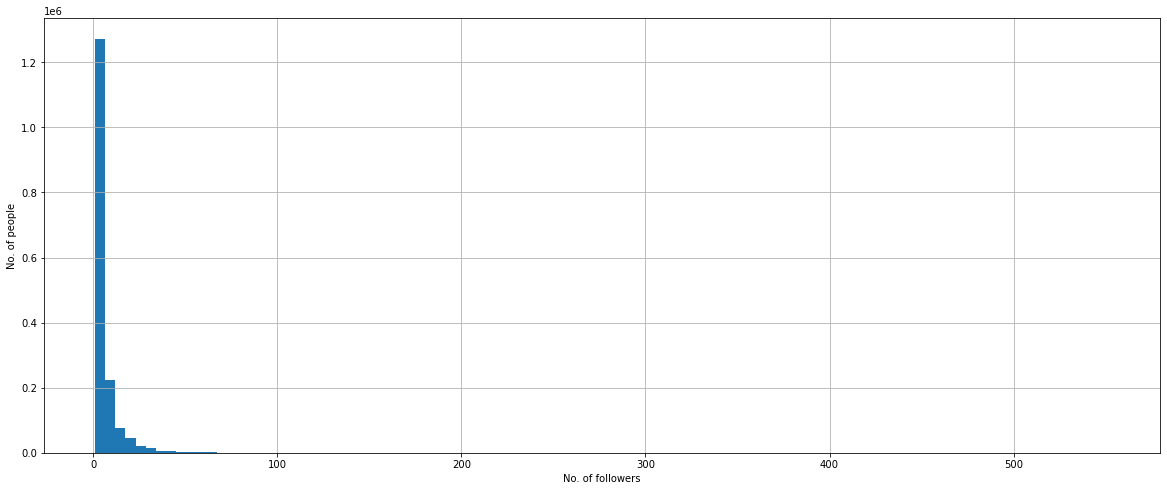

In [16]:
plt.figure(figsize=(20,8))
plt.xlabel('No. of followers')
plt.ylabel('No. of people')
df.groupby(['destination_node']).count()['source_node'].hist(bins=100)

In [17]:
followed_lst = list(df.groupby(['destination_node']).count()['source_node'])
print(followed_lst[:20])
followed_lst.sort()
followed_lst[:20]

[3, 4, 11, 1, 2, 1, 3, 1, 2, 3, 12, 1, 1, 1, 1, 13, 1, 1, 1, 4]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

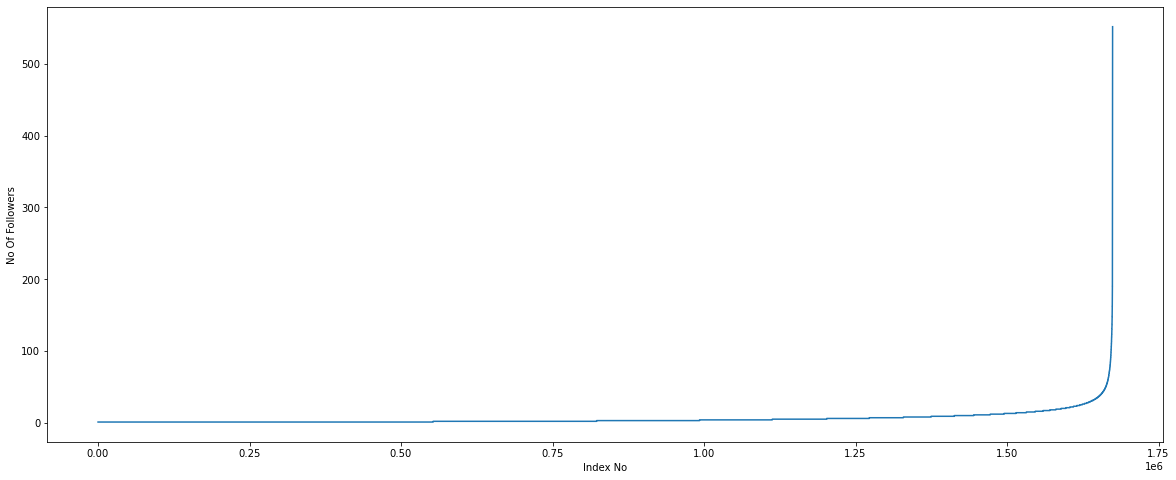

In [18]:
plt.figure(figsize=(20,8))
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.plot(followed_lst)
plt.show()

` Here above we see that, till almost the end of index numbers the graph have an very low slope or growth is very slow i.e. for lager no. if indexes 'no. of followers' is less, but only for some last indexes we have an almost vertical line growth i.e. only some last few indexes have large amount of followers. `


>> - - AAI method

In [19]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(num=1,figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
# plt.show()
plt.close(1) # I have suppressed the output using close()

In [20]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(followed_lst,90+i))

90 percentile value is 13.0
91 percentile value is 14.0
92 percentile value is 15.0
93 percentile value is 16.0
94 percentile value is 18.0
95 percentile value is 20.0
96 percentile value is 22.0
97 percentile value is 25.0
98 percentile value is 31.0
99 percentile value is 42.0
100 percentile value is 552.0


` Here we can see that till the 99% of people have less than 42 followers`

In [21]:
### 99-100 percentile
for i in np.linspace(99,100,11):
    print(i,'percentile value is',np.percentile(followed_lst,i))

99.0 percentile value is 42.0
99.1 percentile value is 44.0
99.2 percentile value is 46.0
99.3 percentile value is 49.0
99.4 percentile value is 53.0
99.5 percentile value is 58.0
99.6 percentile value is 64.0
99.7 percentile value is 73.0
99.8 percentile value is 88.0
99.9 percentile value is 117.0
100.0 percentile value is 552.0


## 1.3) "No of people eache person is following"

In [22]:
follow_lst = list(df.groupby(['source_node']).count()['destination_node'])
print(follow_lst[:20])
follow_lst.sort()
follow_lst[:20]

[3, 6, 6, 2, 2, 1, 3, 1, 2, 1, 1, 3, 12, 1, 1, 15, 5, 1, 1, 1]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

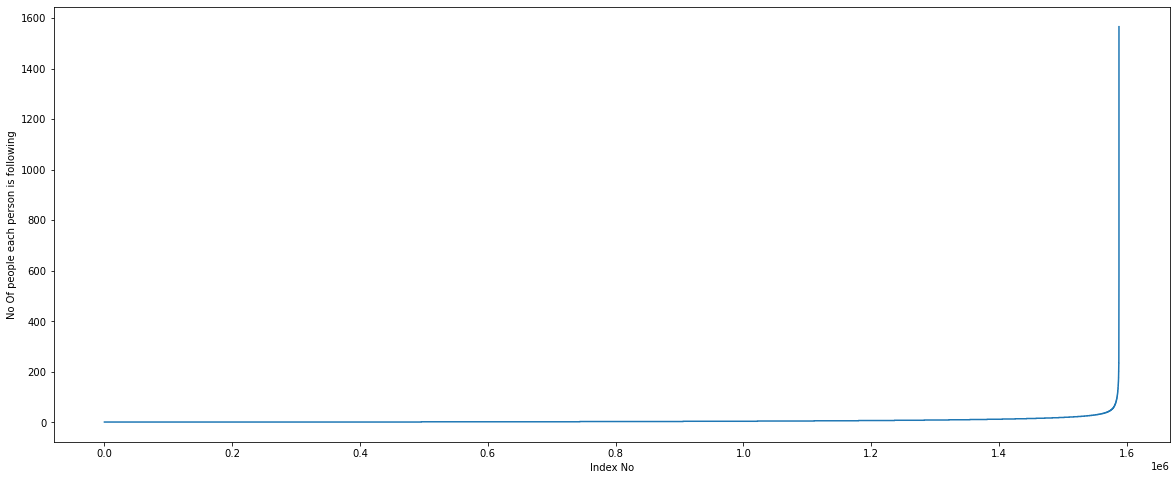

In [23]:
plt.figure(figsize=(20,8))
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.plot(follow_lst)
plt.show()

` Here above we see that, till almost the end of index numbers the graph have an very low slope or growth is very slow i.e. for lager no. if indexes 'no. of people one is following' is less, but only for some last indexes we have an almost vertical line growth i.e. only some last few indexes have people who follow large no. of people upto almost 1600. `


In [24]:
### 90-100 percentile
for i in range(0,9):
    print(90+i,'percentile value is',np.percentile(follow_lst,90+i))
### 99-100 percentile
for i in np.linspace(99,100,11):
    print(i,'percentile value is',np.percentile(follow_lst,i))

90 percentile value is 14.0
91 percentile value is 15.0
92 percentile value is 16.0
93 percentile value is 17.0
94 percentile value is 18.0
95 percentile value is 20.0
96 percentile value is 23.0
97 percentile value is 26.0
98 percentile value is 31.0
99.0 percentile value is 43.0
99.1 percentile value is 46.0
99.2 percentile value is 48.0
99.3 percentile value is 52.0
99.4 percentile value is 56.0
99.5 percentile value is 61.0
99.6 percentile value is 69.0
99.7 percentile value is 80.0
99.8 percentile value is 97.0
99.9 percentile value is 131.0
100.0 percentile value is 1566.0


<AxesSubplot:xlabel='No. of people', ylabel='Total no. of following'>

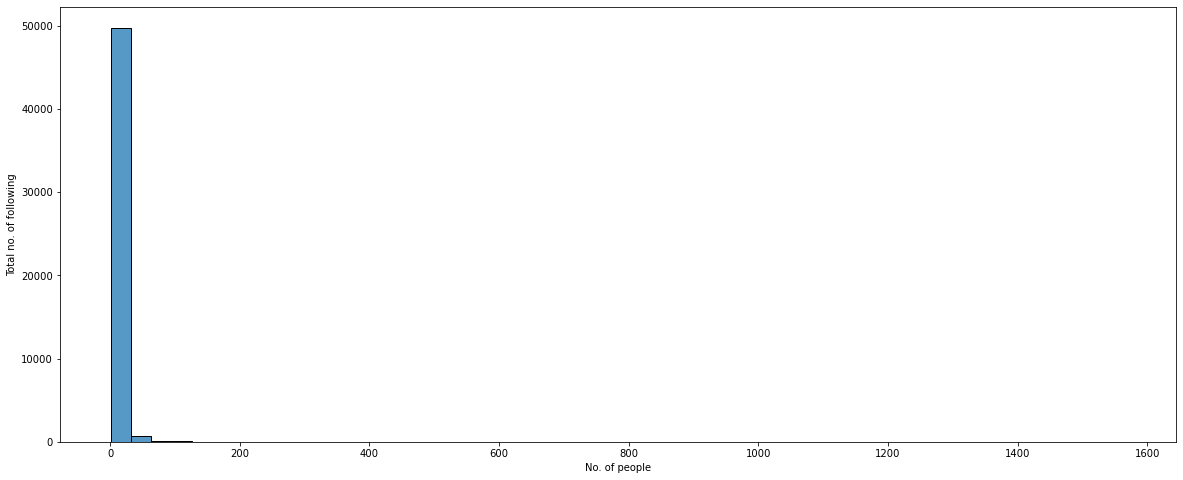

In [25]:
plt.figure(figsize=(20,8))
plt.xlabel('No. of people')
plt.ylabel('Total no. of following')
sns.histplot(follow_lst,stat='frequency',bins=50)

<AxesSubplot:xlabel='No. of people', ylabel='Total no. of following'>

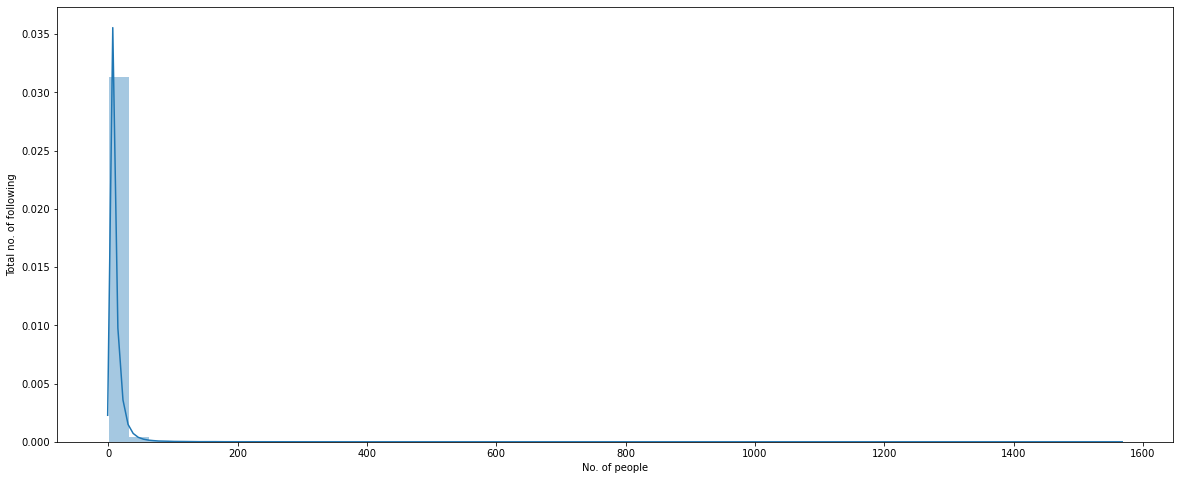

In [26]:
plt.figure(figsize=(20,8))
plt.xlabel('No. of people')
plt.ylabel('Total no. of following')
sns.distplot(follow_lst)

>> - - AAI method

In [27]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(2,figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
# plt.show()
plt.close(2)

In [28]:
pd.Series(follow_lst).value_counts()


1      495824
2      247908
3      161928
4      116251
5       88752
        ...  
312         1
273         1
315         1
316         1
895         1
Length: 326, dtype: int64

In [29]:
pd.Series(outdegree_dist).value_counts()

1      495824
0      274512
2      247908
3      161928
4      116251
        ...  
312         1
273         1
315         1
316         1
895         1
Length: 327, dtype: int64

### `Now from above results we can clearly see that while using our method to get follow_lst we use groupby() but the groupby count() does not consider the grps with 0 as count and hence in the upper result we do not have an number for '0' but using the AAI method i.e. using networkx graph functions we can get the desired results`

In [30]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [31]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [32]:
temp = list(dict(g.degree()).values()) # AAi method
len(temp)

1862220

In [34]:
node_edges_lst = [x for (y,x) in g.degree()] # my method using list comprehensions
len(node_edges_lst)

1862220

In [35]:
node_edges = pd.Series(node_edges_lst)
node_edges[node_edges==0]

Series([], dtype: int64)

` Therefor No. of persons those are not not following anyone and also not having any followers are 0` which is obivious given the format in which the data is provided to us

## 1.4) both followers + following

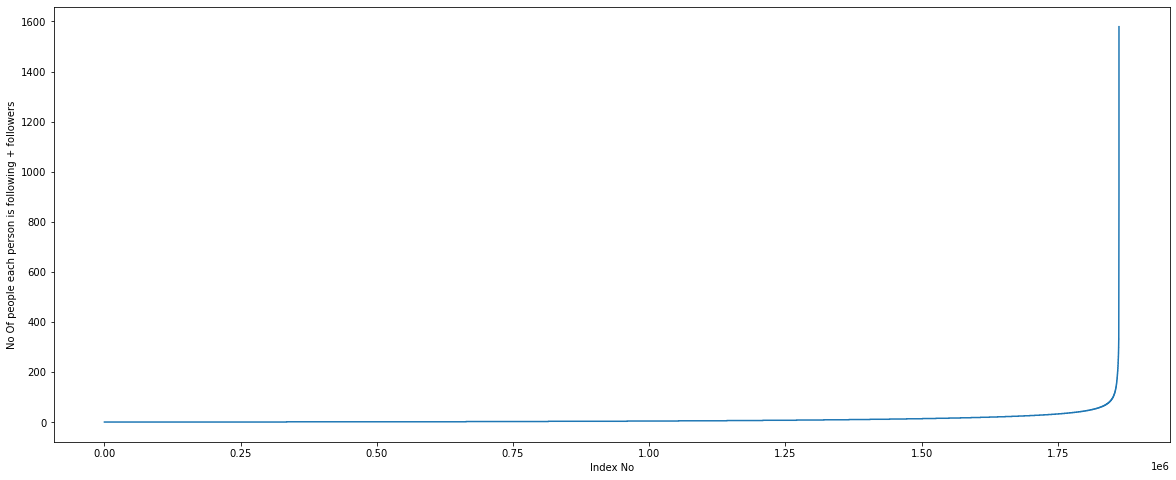

In [36]:
# this is AAI's method to get 'node_edge_lst'

# from collections import Counter
# dict_in = dict(g.in_degree())
# dict_out = dict(g.out_degree())
# d = Counter(dict_in) + Counter(dict_out)
# in_out_degree = np.array(list(d.values()))
# in_out_degree_sort = sorted(in_out_degree)

plt.figure(figsize=(20,8))
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
node_edges_lst.sort()
plt.plot(node_edges_lst)
plt.show()

In [37]:
### 90-100 percentile
for i in range(0,9):
    print(90+i,'percentile value is',np.percentile(node_edges_lst,90+i))
### 99-100 percentile
for i in np.linspace(99,100,11):
    print(i,'percentile value is',np.percentile(node_edges_lst,i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99.0 percentile value is 79.0
99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [38]:
print('Min of no of followers + following is',min(node_edges_lst))
print(node_edges[node_edges==min(node_edges_lst)].shape[0],' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [39]:
print('Max of no of followers + following is',max(node_edges_lst))
print(node_edges[node_edges==max(node_edges_lst)].shape[0],' persons having maximum no of followers + following')
###########  OR
print(sum(node_edges == max(node_edges_lst)),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following
1  persons having maximum no of followers + following


In [40]:
print('No of persons having followers + following less than 10 are',sum(node_edges < 10))

No of persons having followers + following less than 10 are 1320326


In [41]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


# 2. Posing a problem as classification problem 

>> * ### Here if we observe closely we can see that with the data provided to us we can produce it as classification problem -> say the data has source node as 53 and destination node as 121, then we map as x- 153,121 and y-1. We will put y = 1 when the pair of edges in the X are directly connected by an edge. 
>> * ### So the data we have is for the connected edges, hence for all data y=1. Therefore we have only the data for y=1, making it completely imbalanced. But we can formulate y=0 data by considering other unconnected egdes. 
> * ### For each node in the data we have n-1 possible connections in an directed graph. So in an directed graph of n nodes in total of n(n-1) edges/connections are possible. According to our data we have 1.8M Nodes and 9.43M connected edges. So our graph have (1.8*10^6)*(1.8*10^6 - 1) which is in something in order of 10^12, which is tremendiously large number. So the no. of unconnected edges = 10^12 - 9.43*10^6, which is an very small number. So now if we cansider all the unconnected egdes the data again becomes completely imbalanced.
> * ### So to create an perfecty balanced data, we will sample 9.43M unconnected egdes from the 10^12 combinations. Therefore we will be having 9.43M datapoints of y=1 and y=0.

In [42]:
len(g.nodes())

1862220

In [43]:
len(g.edges())

9437519

In [46]:
y0data = set()
nlst = list(g.nodes())
# for x in g.nodes():
#     for y in g.nodes():
#         if x!=y and (x,y) not in g.edges():
#             y0data.append((x,y))
while (len(y0data) < 9437519):
    x = random.choice(nlst)
    y = random.choice(nlst)
    if x!=y and (x,y) not in g.edges():
        try:
            if nx.shortest_path_length(g,source=x,target=y) > 2: 
                y0data.add((x,y))
            else:
                continue  
        except:  
            y0data.add((x,y))              
    else:
        continue


In [48]:
len(y0data)

1000000

In [ ]:
r = csv.reader(open('datasets/data/after_eda/train_woheader.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

In [ ]:
missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue

# 3. Train -Test Split

` Now here in real case senario, this graph would me changing at ever other second in Facebook data centre. So considering that we would have used the time based slpit. But in this case study unfortunately we only have data at any time 't'. So we are left with random split`.